<a href="https://colab.research.google.com/github/cestclaire/programmers_project_results/blob/main/Attention_is_All_You_Need_Tutorial__English_Korean_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Attention is All You Need (NIPS 2017)** 실습
* <b>(뉴스 데이터셋)</b> 영어 문장을 한국어 문장으로 번역합니다.
* 본 코드는 기본적으로 **Transformer** 논문의 내용을 최대한 따릅니다.
    * 본 논문은 **딥러닝 기반의 자연어 처리** 기법의 기본적인 구성을 이해하고 공부하는 데에 도움을 줍니다.
    * 2020년 기준 가장 뛰어난 번역 모델들은 본 논문에서 제안한 **Transformer 기반의 아키텍처**를 따르고 있습니다.
* 코드 실행 전에 **[런타임]** → **[런타임 유형 변경]** → 유형을 **GPU**로 설정합니다.

#### <b>한글 출력을 위한 폰트 설치</b>

* 설치 이후에 수동으로 <b>[런타임]</b> - <b>[런타임 다시 시작]</b> 버튼을 눌러 재시작합니다.

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 27 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 3s (3,194 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

#### <b>한글 토큰화 라이브러리 설치하기</b>


In [ ]:
!pip3 install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 7.9 MB/s 
     |████████████████████████████████| 453 kB 61.6 MB/s 


#### <b>데이터셋 다운로드</b>

* 한영 번역 데이터셋을 다운로드하여 파이썬 객체로 불러옵니다.

In [ ]:
# 한영 번역 데이터셋을 포함하는 저장소
!git clone https://github.com/ndb796/korean-parallel-corpora

Cloning into 'korean-parallel-corpora'...
remote: Enumerating objects: 131, done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 131
Receiving objects: 100% (131/131), 17.67 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [ ]:
# 데이터셋이 저장될 폴더 생성
!mkdir -p ./dataset

# 압축 해제
!tar -xvf ./korean-parallel-corpora/korean-english-news-v1/korean-english-park.train.tar.gz -C ./dataset
!tar -xvf ./korean-parallel-corpora/korean-english-news-v1/korean-english-park.test.tar.gz -C ./dataset
!tar -xvf ./korean-parallel-corpora/korean-english-news-v1/korean-english-park.dev.tar.gz -C ./dataset

# 학습(training) 데이터셋 이름 변경
!mv ./dataset/korean-english-park.train.en ./dataset/train.en
!mv ./dataset/korean-english-park.train.ko ./dataset/train.ko

# 평가(validation) 데이터셋 이름 변경
!mv ./dataset/korean-english-park.dev.en ./dataset/dev.en
!mv ./dataset/korean-english-park.dev.ko ./dataset/dev.ko

# 테스트(test) 데이터셋 이름 변경
!mv ./dataset/korean-english-park.test.en ./dataset/test.en
!mv ./dataset/korean-english-park.test.ko ./dataset/test.ko

korean-english-park.train.en
korean-english-park.train.ko
korean-english-park.test.en
korean-english-park.test.ko
korean-english-park.dev.en
korean-english-park.dev.ko


#### <b>데이터셋 읽어 확인하기</b>

* 학습, 평가, 테스트 데이터셋을 각각 읽어 문장 데이터를 확인합니다.

In [ ]:
korean_lines_train = open("./dataset/train.ko", 'r', encoding='utf-8').readlines()
english_lines_train = open("./dataset/train.en", 'r', encoding='utf-8').readlines()

korean_lines_val = open("./dataset/dev.ko", 'r', encoding='utf-8').readlines()
english_lines_val = open("./dataset/dev.en", 'r', encoding='utf-8').readlines()

korean_lines_test = open("./dataset/test.ko", 'r', encoding='utf-8').readlines()
english_lines_test = open("./dataset/test.en", 'r', encoding='utf-8').readlines()

In [ ]:
print(f"한글 문장 학습 데이터 개수: {len(korean_lines_train)}개")
print(f"영어 문장 학습 데이터 개수: {len(english_lines_train)}개")

print(f"한글 문장 평가 데이터 개수: {len(korean_lines_val)}개")
print(f"영어 문장 평가 데이터 개수: {len(english_lines_val)}개")

print(f"한글 문장 테스트 데이터 개수: {len(korean_lines_test)}개")
print(f"영어 문장 테스트 데이터 개수: {len(english_lines_test)}개")

index = 777
print(f"{index + 1}번째 학습용 한글 문장:", korean_lines_train[index], end='')
print(f"{index + 1}번째 학습용 영어 문장:", english_lines_train[index], end='')

한글 문장 학습 데이터 개수: 94123개
영어 문장 학습 데이터 개수: 94123개
한글 문장 평가 데이터 개수: 1000개
영어 문장 평가 데이터 개수: 1000개
한글 문장 테스트 데이터 개수: 2000개
영어 문장 테스트 데이터 개수: 2000개
778번째 학습용 한글 문장: 지금 21살인 유는 학교에 가기 전 서너시간 동안 컴퓨터 통신에 끼어들기 위해 새벽 5시에 침대에서 일어나 나온다.
778번째 학습용 영어 문장: Now Yu, 21, drags herself out of bed at 5 a.m. to squeeze in a few hours online before school.


#### <b>단어 사전 만들기 </b>

* 단어 사전 클래스를 정의합니다.

In [ ]:
class Vocabulary(object):
    def __init__(self):
        self.UNK = '<unk>'
        self.PAD = '<pad>'
        self.SOS = '<sos>'
        self.EOS = '<eos>'

        self.word2idx = {}
        self.idx2word = {}
        self.word2count = {}

    # 하나의 문장(sentence)에 포함된 모든 토큰을 추가하는 함수
    def add_tokens(self, tokens):
        for word in tokens:
            if word in self.word2count:
                self.word2count[word] += 1
            else:
                self.word2count[word] = 1

    def preprocess(self, min_count):
        # 사용하지 않을 단어 집합
        trim_words = set()
        for word, count in self.word2count.items():
            if count < min_count:
                trim_words.add(word)

        # 실제로 사용할 단어만 남기기
        words = set(self.word2count.keys()) - trim_words
        words = [self.UNK, self.PAD, self.SOS, self.EOS] + list(words)

        self.word2idx = {}
        self.idx2word = {}
        for i, word in enumerate(words):
            self.word2idx[word] = i
            self.idx2word[i] = word

#### <b>문장 토큰화</b>

* 먼저 한글 문장 및 영어 문장 데이터셋에 대하여 토큰화를 수행합니다.
* 토큰화를 위해 특수문자 제거 함수를 정의하고 객체를 초기화합니다.

In [ ]:
import re
from konlpy.tag import Okt

def clean_string(string):
    string = string.strip() # 앞뒤로 존재하는 공백 제거
    string = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', string) # 특수문자 제거
    return string.strip().lower() # 소문자로 변환하여 반환

okt = Okt() # 한글 형태소 분석기

* 학습(training) 데이터셋을 토큰화합니다.

In [ ]:
tokenized_korean_lines_train = []
tokenized_english_lines_train = []

min_length = 4 # 단어의 개수가 4개 이상인 학습 문장 쌍만 사용
max_length = 50 # 단어의 개수가 50개 이하인 학습 문장 쌍만 사용

for i in range(len(korean_lines_train)):
    korean = korean_lines_train[i]
    korean = clean_string(korean)
    korean_tokens = [line[0] for line in okt.pos(korean, norm=True)] # 한글 형태소 분석 결과 추출

    english = english_lines_train[i]
    english = clean_string(english)
    english_tokens = english.split(' ')

    if len(korean_tokens) < min_length or len(korean_tokens) > max_length:
        continue
    if len(english_tokens) < min_length or len(english_tokens) > max_length:
        continue

    tokenized_korean_lines_train.append(korean_tokens)
    tokenized_english_lines_train.append(english_tokens)

    if (i + 1) % 4000 == 0:
        print(f"학습 데이터셋 토큰화: {i + 1}/{len(korean_lines_train)}")

학습 데이터셋 토큰화: 4000/94123
학습 데이터셋 토큰화: 8000/94123
학습 데이터셋 토큰화: 12000/94123
학습 데이터셋 토큰화: 16000/94123
학습 데이터셋 토큰화: 20000/94123
학습 데이터셋 토큰화: 24000/94123
학습 데이터셋 토큰화: 28000/94123
학습 데이터셋 토큰화: 32000/94123
학습 데이터셋 토큰화: 36000/94123
학습 데이터셋 토큰화: 40000/94123
학습 데이터셋 토큰화: 44000/94123
학습 데이터셋 토큰화: 48000/94123
학습 데이터셋 토큰화: 52000/94123
학습 데이터셋 토큰화: 56000/94123
학습 데이터셋 토큰화: 60000/94123
학습 데이터셋 토큰화: 64000/94123
학습 데이터셋 토큰화: 68000/94123
학습 데이터셋 토큰화: 72000/94123
학습 데이터셋 토큰화: 76000/94123
학습 데이터셋 토큰화: 80000/94123
학습 데이터셋 토큰화: 84000/94123
학습 데이터셋 토큰화: 88000/94123
학습 데이터셋 토큰화: 92000/94123


* 평가(validation) 데이터셋을 토큰화합니다.

In [ ]:
tokenized_korean_lines_val = []
tokenized_english_lines_val = []

for i in range(len(korean_lines_val)):
    korean = korean_lines_val[i]
    korean = clean_string(korean)
    korean_tokens = [line[0] for line in okt.pos(korean, norm=True)] # 한글 형태소 분석 결과 추출

    english = english_lines_val[i]
    english = clean_string(english)
    english_tokens = english.split(' ')

    tokenized_korean_lines_val.append(korean_tokens)
    tokenized_english_lines_val.append(english_tokens)

    if (i + 1) % 1000 == 0:
        print(f"평가 데이터셋 토큰화: {i + 1}/{len(korean_lines_val)}")

평가 데이터셋 토큰화: 1000/1000


* 테스트(test) 데이터셋을 토큰화합니다.

In [ ]:
tokenized_korean_lines_test = []
tokenized_english_lines_test = []

for i in range(len(korean_lines_test)):
    korean = korean_lines_test[i]
    korean = clean_string(korean)
    korean_tokens = [line[0] for line in okt.pos(korean, norm=True)] # 한글 형태소 분석 결과 추출

    english = english_lines_test[i]
    english = clean_string(english)
    english_tokens = english.split(' ')

    tokenized_korean_lines_test.append(korean_tokens)
    tokenized_english_lines_test.append(english_tokens)

    if (i + 1) % 1000 == 0:
        print(f"테스트 데이터셋 토큰화: {i + 1}/{len(korean_lines_test)}")

테스트 데이터셋 토큰화: 1000/2000
테스트 데이터셋 토큰화: 2000/2000


#### <b>단어 사전 만들기</b>

* 최소 2번 이상 등장한 단어만 사용합니다.

In [ ]:
korean_voca = Vocabulary()
english_voca = Vocabulary()

for i in range(len(tokenized_korean_lines_train)):
    korean_tokens = tokenized_korean_lines_train[i]
    english_tokens = tokenized_english_lines_train[i]

    korean_voca.add_tokens(korean_tokens)
    english_voca.add_tokens(english_tokens)

korean_voca.preprocess(min_count=2)
english_voca.preprocess(min_count=2)

print("전체 한국어 단어 수:", len(korean_voca.word2count))
print("전체 영어 단어 수:", len(english_voca.word2count))
print("사용할 한국어 토큰 수:", len(korean_voca.word2idx))
print("사용할 영어 토큰 수:", len(english_voca.word2idx))

전체 한국어 단어 수: 67029
전체 영어 단어 수: 58833
사용할 한국어 토큰 수: 40612
사용할 영어 토큰 수: 35745


In [ ]:
print(korean_voca.word2idx['<pad>']) # 패딩(padding): 1
print(korean_voca.word2idx['<sos>']) # <sos>: 2
print(korean_voca.word2idx['<eos>']) # <eos>: 3
print(korean_voca.word2idx['컴퓨터'])
print(korean_voca.word2idx['사랑'])
print(korean_voca.word2idx['기적'])

1
2
3
11902
24095
4833


In [ ]:
print(english_voca.word2idx['<pad>']) # 패딩(padding): 1
print(english_voca.word2idx['<sos>']) # <sos>: 2
print(english_voca.word2idx['<eos>']) # <eos>: 3
print(english_voca.word2idx['computer'])
print(english_voca.word2idx['love'])
print(english_voca.word2idx['miracle'])

1
2
3
820
8513
7668


* Unknown Token이 1개 이상 포함된 문장은 데이터셋에서 제외하여 다시 학습 데이터셋을 구성합니다.

In [ ]:
unknown_threshold = 1

preprocessed_korean_lines_train = []
preprocessed_english_lines_train = []

for i in range(len(tokenized_korean_lines_train)):
    korean_tokens = tokenized_korean_lines_train[i]
    english_tokens = tokenized_english_lines_train[i]

    is_used = True # 현재의 문장 쌍을 사용할지의 여부
    for token in korean_tokens:
        cnt = 0
        if token not in korean_voca.word2idx:
            cnt += 1
        if cnt >= unknown_threshold:
            is_used = False
    for token in english_tokens:
        cnt = 0
        if token not in english_voca.word2idx:
            cnt += 1
        if cnt >= unknown_threshold:
            is_used = False

    if not is_used:
        continue

    preprocessed_korean_lines_train.append(korean_tokens)
    preprocessed_english_lines_train.append(english_tokens)

In [ ]:
print("사용할 한국어 학습 문장 수:", len(preprocessed_korean_lines_train))
print("사용할 영어 학습 문장 수:", len(preprocessed_english_lines_train))

사용할 한국어 학습 문장 수: 61029
사용할 영어 학습 문장 수: 61029


In [ ]:
print(preprocessed_korean_lines_train[7777])
print(preprocessed_english_lines_train[7777])

['cnn', '의', '여론조사', '국장', '인', '키팅', '홀랜드', '는', '“', '이라크전', '발발', '직후', '부시', '의', '지지도', '는', '71', '였다', '”', '며', '“', '지지율', '40', '추락', '은', '베트남전', '당시', '린', '든', '존슨', '대통령', '과', '유사하다', '”', '고', '지적', '했다']
['bushs', 'approval', 'rating', 'five', 'years', 'ago', 'at', 'the', 'start', 'of', 'the', 'iraq', 'war', 'was', '71', 'percent', 'and', 'that', '40point', 'drop', 'is', 'almost', 'identical', 'to', 'the', 'drop', 'president', 'lyndon', 'johnson', 'faced', 'during', 'the', 'vietnam', 'war', 'said', 'cnn', 'polling', 'director', 'keating', 'holland']


#### <b>커스텀 데이터셋 클래스 작성하기</b>

* 소스 문장(영어)과 타겟 문장(한국어)를 한 쌍으로 반환하는 데이터셋 클래스를 정의합니다.

In [ ]:
import copy
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, korean_lines, english_lines, max_seq_len):
        self.korean_lines = korean_lines
        self.english_lines = english_lines
        self.max_seq_len = max_seq_len

    def __getitem__(self, index):
        encoder_input = self.get_encoder_input(self.english_lines[index])
        decoder_input = self.get_decoder_input(self.korean_lines[index])

        return encoder_input, decoder_input

    def __len__(self):
        return len(self.korean_lines)

    # 영어 문장 벡터화
    def get_encoder_input(self, tokens):
        tokens = copy.deepcopy(tokens)
        tokens.insert(0, english_voca.SOS)
        tokens.append(english_voca.EOS)
        tokens = self.padding(tokens, english_voca) # 문장 뒤쪽에 패딩 붙이기
        index_list = self.word2idx(tokens, english_voca)

        return torch.tensor(index_list).to(device)

    # 한글 문장 벡터화
    def get_decoder_input(self, tokens):
        tokens = copy.deepcopy(tokens)
        tokens.insert(0, korean_voca.SOS)
        tokens.append(korean_voca.EOS)
        tokens = self.padding(tokens, korean_voca) # 문장 뒤쪽에 패딩 붙이기
        index_list = self.word2idx(tokens, korean_voca)

        return torch.tensor(index_list).to(device)

    # max_seq_len보다 길이가 짧은 문장에 대해 <pad> 토큰 채우기
    def padding(self, tokens, voca):
        if len(tokens) < self.max_seq_len:
            tokens += [voca.PAD] * (self.max_seq_len - len(tokens))
        else:
            tokens = tokens[:self.max_seq_len]
        return tokens

    def word2idx(self, tokens, voca):
        idx_list = []
        for token in tokens:
            try:
                idx_list.append(voca.word2idx[token])
            except KeyError:
                idx_list.append(voca.word2idx[voca.UNK])
        return idx_list

* 학습/평가/테스트 데이터셋 객체를 초기화합니다.

In [ ]:
import torch
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_dataset = CustomDataset(preprocessed_korean_lines_train, preprocessed_english_lines_train, max_seq_len=80)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128, num_workers=0)

val_dataset = CustomDataset(tokenized_korean_lines_val, tokenized_english_lines_val, max_seq_len=80)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=128, num_workers=0)

test_dataset = CustomDataset(tokenized_korean_lines_test, tokenized_english_lines_test, max_seq_len=80)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128, num_workers=0)

In [ ]:
# 하나의 배치에 포함되어 있는 문장을 출력합니다.
for i, batch in enumerate(train_loader):
    src = batch[0]
    trg = batch[1]

    print(f"첫 번째 배치 크기: {src.shape}")

    # 현재 배치에 있는 하나의 문장에 포함된 정보 출력
    for i in range(src.shape[1]):
        print(f"인덱스 {i}: {src[0][i].item()}") # 여기에서는 [Seq_num, Seq_len]

    # 첫 번째 배치만 확인
    break

첫 번째 배치 크기: torch.Size([128, 80])
인덱스 0: 2
인덱스 1: 7150
인덱스 2: 7319
인덱스 3: 28057
인덱스 4: 18853
인덱스 5: 13359
인덱스 6: 16871
인덱스 7: 23676
인덱스 8: 17149
인덱스 9: 2622
인덱스 10: 27687
인덱스 11: 10588
인덱스 12: 3
인덱스 13: 1
인덱스 14: 1
인덱스 15: 1
인덱스 16: 1
인덱스 17: 1
인덱스 18: 1
인덱스 19: 1
인덱스 20: 1
인덱스 21: 1
인덱스 22: 1
인덱스 23: 1
인덱스 24: 1
인덱스 25: 1
인덱스 26: 1
인덱스 27: 1
인덱스 28: 1
인덱스 29: 1
인덱스 30: 1
인덱스 31: 1
인덱스 32: 1
인덱스 33: 1
인덱스 34: 1
인덱스 35: 1
인덱스 36: 1
인덱스 37: 1
인덱스 38: 1
인덱스 39: 1
인덱스 40: 1
인덱스 41: 1
인덱스 42: 1
인덱스 43: 1
인덱스 44: 1
인덱스 45: 1
인덱스 46: 1
인덱스 47: 1
인덱스 48: 1
인덱스 49: 1
인덱스 50: 1
인덱스 51: 1
인덱스 52: 1
인덱스 53: 1
인덱스 54: 1
인덱스 55: 1
인덱스 56: 1
인덱스 57: 1
인덱스 58: 1
인덱스 59: 1
인덱스 60: 1
인덱스 61: 1
인덱스 62: 1
인덱스 63: 1
인덱스 64: 1
인덱스 65: 1
인덱스 66: 1
인덱스 67: 1
인덱스 68: 1
인덱스 69: 1
인덱스 70: 1
인덱스 71: 1
인덱스 72: 1
인덱스 73: 1
인덱스 74: 1
인덱스 75: 1
인덱스 76: 1
인덱스 77: 1
인덱스 78: 1
인덱스 79: 1


#### **Multi Head Attention 아키텍처**

* 어텐션(attention)은 <b>세 가지 요소</b>를 입력으로 받습니다.
    * <b>쿼리(queries)</b>
    * <b>키(keys)</b>
    * <b>값(values)</b>
    * 현재 구현에서는 Query, Key, Value의 차원이 모두 같습니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [ ]:
import torch.nn as nn

class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, dropout_ratio, device):
        super().__init__()

        assert hidden_dim % n_heads == 0

        self.hidden_dim = hidden_dim # 임베딩 차원
        self.n_heads = n_heads # 헤드(head)의 개수: 서로 다른 어텐션(attention) 컨셉의 수
        self.head_dim = hidden_dim // n_heads # 각 헤드(head)에서의 임베딩 차원

        self.fc_q = nn.Linear(hidden_dim, hidden_dim) # Query 값에 적용될 FC 레이어
        self.fc_k = nn.Linear(hidden_dim, hidden_dim) # Key 값에 적용될 FC 레이어
        self.fc_v = nn.Linear(hidden_dim, hidden_dim) # Value 값에 적용될 FC 레이어

        self.fc_o = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        # query: [batch_size, query_len, hidden_dim]
        # key: [batch_size, key_len, hidden_dim]
        # value: [batch_size, value_len, hidden_dim]
 
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q: [batch_size, query_len, hidden_dim]
        # K: [batch_size, key_len, hidden_dim]
        # V: [batch_size, value_len, hidden_dim]

        # hidden_dim → n_heads X head_dim 형태로 변형
        # n_heads(h)개의 서로 다른 어텐션(attention) 컨셉을 학습하도록 유도
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Q: [batch_size, n_heads, query_len, head_dim]
        # K: [batch_size, n_heads, key_len, head_dim]
        # V: [batch_size, n_heads, value_len, head_dim]

        # Attention Energy 계산
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        # energy: [batch_size, n_heads, query_len, key_len]

        # 마스크(mask)를 사용하는 경우
        if mask is not None:
            # 마스크(mask) 값이 0인 부분을 -1e10으로 채우기
            energy = energy.masked_fill(mask==0, -1e10)

        # 어텐션(attention) 스코어 계산: 각 단어에 대한 확률 값
        attention = torch.softmax(energy, dim=-1)

        # attention: [batch_size, n_heads, query_len, key_len]

        # 여기에서 Scaled Dot-Product Attention을 계산
        x = torch.matmul(self.dropout(attention), V)

        # x: [batch_size, n_heads, query_len, head_dim]

        x = x.permute(0, 2, 1, 3).contiguous()

        # x: [batch_size, query_len, n_heads, head_dim]

        x = x.view(batch_size, -1, self.hidden_dim)

        # x: [batch_size, query_len, hidden_dim]

        x = self.fc_o(x)

        # x: [batch_size, query_len, hidden_dim]

        return x, attention

#### **Position-wise Feedforward 아키텍처**

* 입력과 출력의 차원이 동일합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hidden_dim, pf_dim, dropout_ratio):
        super().__init__()

        self.fc_1 = nn.Linear(hidden_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hidden_dim)

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):

        # x: [batch_size, seq_len, hidden_dim]

        x = self.dropout(torch.relu(self.fc_1(x)))

        # x: [batch_size, seq_len, pf_dim]

        x = self.fc_2(x)

        # x: [batch_size, seq_len, hidden_dim]

        return x

#### **인코더(Encoder) 레이어 아키텍처**

* 하나의 인코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 인코더는 인코더 레이어를 여러 번 중첩해 사용합니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 하나의 임베딩이 복제되어 Query, Key, Value로 입력되는 방식
    def forward(self, src, src_mask):

        # src: [batch_size, src_len, hidden_dim]
        # src_mask: [batch_size, src_len]

        # self attention
        # 필요한 경우 마스크(mask) 행렬을 이용하여 어텐션(attention)할 단어를 조절 가능
        _src, _ = self.self_attention(src, src, src, src_mask)

        # dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        # position-wise feedforward
        _src = self.positionwise_feedforward(src)

        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))

        # src: [batch_size, src_len, hidden_dim]

        return src

#### **인코더(Encoder) 아키텍처**

* 전체 인코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **input_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, src, src_mask):

        # src: [batch_size, src_len]
        # src_mask: [batch_size, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, src_len]

        # 소스 문장의 임베딩과 위치 임베딩을 더한 것을 사용
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))

        # src: [batch_size, src_len, hidden_dim]

        # 모든 인코더 레이어를 차례대로 거치면서 순전파(forward) 수행
        for layer in self.layers:
            src = layer(src, src_mask)

        # src: [batch_size, src_len, hidden_dim]

        return src # 마지막 레이어의 출력을 반환

#### **디코더(Decoder) 레이어 아키텍처**

* 하나의 디코더 레이어에 대해 정의합니다.
    * 입력과 출력의 차원이 같습니다.
    * 이러한 특징을 이용해 트랜스포머의 디코더는 디코더 레이어를 여러 번 중첩해 사용합니다.
    * 디코더 레이어에서는 두 개의 Multi-Head Attention 레이어가 사용됩니다.
* 하이퍼 파라미터(hyperparameter)
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, pf_dim, dropout_ratio, device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hidden_dim)
        self.ff_layer_norm = nn.LayerNorm(hidden_dim)
        self.self_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.encoder_attention = MultiHeadAttentionLayer(hidden_dim, n_heads, dropout_ratio, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hidden_dim, pf_dim, dropout_ratio)
        self.dropout = nn.Dropout(dropout_ratio)

    # 인코더의 출력 값(enc_src)을 어텐션(attention)하는 구조
    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len, hidden_dim]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        # self attention
        # 자기 자신에 대하여 어텐션(attention)
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        # dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # encoder attention
        # 디코더의 쿼리(Query)를 이용해 인코더를 어텐션(attention)
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        # dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]

        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)

        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return trg, attention

#### **디코더(Decoder) 아키텍처**

* 전체 디코더 아키텍처를 정의합니다.
* 하이퍼 파라미터(hyperparameter)
    * **output_dim**: 하나의 단어에 대한 원 핫 인코딩 차원
    * **hidden_dim**: 하나의 단어에 대한 임베딩 차원
    * **n_layers**: 내부적으로 사용할 인코더 레이어의 개수
    * **n_heads**: 헤드(head)의 개수 = scaled dot-product attention의 개수
    * **pf_dim**: Feedforward 레이어에서의 내부 임베딩 차원
    * **dropout_ratio**: 드롭아웃(dropout) 비율
    * **max_length**: 문장 내 최대 단어 개수
* 원본 논문과는 다르게 <b>위치 임베딩(positional embedding)을 학습</b>하는 형태로 구현합니다.
    * BERT와 같은 모던 트랜스포머 아키텍처에서 사용되는 방식입니다.
* Seq2Seq과는 마찬가지로 실제로 추론(inference) 시기에서는 디코더를 반복적으로 넣을 필요가 있습니다.
    * 학습(training) 시기에서는 한 번에 출력 문장을 구해 학습할 수 있습니다.
* 소스 문장의 &lt;pad&gt; 토큰에 대하여 마스크(mask) 값을 0으로 설정합니다.
* 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용합니다.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, n_heads, pf_dim, dropout_ratio, device, max_length=100):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_length, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, pf_dim, dropout_ratio, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hidden_dim, output_dim)

        self.dropout = nn.Dropout(dropout_ratio)

        self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        # trg: [batch_size, trg_len]
        # enc_src: [batch_size, src_len, hidden_dim]
        # trg_mask: [batch_size, trg_len]
        # src_mask: [batch_size, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # pos: [batch_size, trg_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))

        # trg: [batch_size, trg_len, hidden_dim]

        for layer in self.layers:
            # 소스 마스크와 타겟 마스크 모두 사용
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg_len, hidden_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        # output: [batch_size, trg_len, output_dim]

        return output, attention

#### **트랜스포머(Transformer) 아키텍처**

* 최종적인 전체 트랜스포머(Transformer) 모델을 정의합니다.
* 입력이 들어왔을 때 앞서 정의한 인코더와 디코더를 거쳐 출력 문장을 생성합니다.

In [ ]:
class Transformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    # 소스 문장의 <pad> 토큰에 대하여 마스크(mask) 값을 0으로 설정
    def make_src_mask(self, src):

        # src: [batch_size, src_len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        # src_mask: [batch_size, 1, 1, src_len]

        return src_mask

    # 타겟 문장에서 각 단어는 다음 단어가 무엇인지 알 수 없도록(이전 단어만 보도록) 만들기 위해 마스크를 사용
    def make_trg_mask(self, trg):

        # trg: [batch_size, trg_len]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 0 0
        1 1 1 0 0
        """
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        # trg_pad_mask: [batch_size, 1, 1, trg_len]

        trg_len = trg.shape[1]

        """ (마스크 예시)
        1 0 0 0 0
        1 1 0 0 0
        1 1 1 0 0
        1 1 1 1 0
        1 1 1 1 1
        """
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        # trg_sub_mask: [trg_len, trg_len]

        trg_mask = trg_pad_mask & trg_sub_mask

        # trg_mask: [batch_size, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        # src: [batch_size, src_len]
        # trg: [batch_size, trg_len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask: [batch_size, 1, 1, src_len]
        # trg_mask: [batch_size, 1, trg_len, trg_len]

        enc_src = self.encoder(src, src_mask)

        # enc_src: [batch_size, src_len, hidden_dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output: [batch_size, trg_len, output_dim]
        # attention: [batch_size, n_heads, trg_len, src_len]

        return output, attention

#### **학습(Training)**

* 하이퍼 파라미터 설정 및 모델 초기화

In [ ]:
INPUT_DIM = len(english_voca.word2idx)
OUTPUT_DIM = len(korean_voca.word2idx)
HIDDEN_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

In [ ]:
SRC_PAD_IDX = english_voca.word2idx[english_voca.PAD]
TRG_PAD_IDX = korean_voca.word2idx[korean_voca.PAD]

# 인코더(encoder)와 디코더(decoder) 객체 선언
enc = Encoder(INPUT_DIM, HIDDEN_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, HIDDEN_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# Transformer 객체 선언
model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

* **모델 가중치 파라미터 초기화**

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 33,989,540 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights)

Transformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(35745, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )


* 학습 및 평가 함수 정의
    * 기본적인 Seq2Seq 모델과 거의 유사하게 작성할 수 있습니다.

In [ ]:
import torch.optim as optim

# Adam optimizer로 학습 최적화
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 뒷 부분의 패딩(padding)에 대해서는 값 무시
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
# 모델 학습(train) 함수
def train(model, iterator, optimizer, criterion, clip):
    model.train() # 학습 모드
    epoch_loss = 0

    # 전체 학습 데이터를 확인하며
    for i, batch in enumerate(iterator):
        src = batch[0]
        trg = batch[1]

        optimizer.zero_grad()

        # 출력 단어의 마지막 인덱스(<eos>)는 제외
        # 입력을 할 때는 <sos>부터 시작하도록 처리
        output, _ = model(src, trg[:,:-1]) # output에 마지막이 <eos>가 나오도록

        # output: [배치 크기, trg_len - 1, output_dim]
        # trg: [배치 크기, trg_len]

        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        # 출력 단어의 인덱스 0(<sos>)은 제외
        trg = trg[:,1:].contiguous().view(-1) # <eos>가 붙어 있는 상황

        # output: [배치 크기 * trg_len - 1, output_dim]
        # trg: [배치 크기 * trg len - 1]

        # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
        loss = criterion(output, trg)
        loss.backward() # 기울기(gradient) 계산

        # 기울기(gradient) clipping 진행
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # 파라미터 업데이트
        optimizer.step()

        # 전체 손실 값 계산
        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

In [ ]:
# 모델 평가(evaluate) 함수
def evaluate(model, iterator, criterion):
    model.eval() # 평가 모드
    epoch_loss = 0

    with torch.no_grad():
        # 전체 평가 데이터를 확인하며
        for i, batch in enumerate(iterator):
            src = batch[0]
            trg = batch[1]

            # 출력 단어의 마지막 인덱스(<eos>)는 제외
            # 입력을 할 때는 <sos>부터 시작하도록 처리
            output, _ = model(src, trg[:,:-1])

            # output: [배치 크기, trg_len - 1, output_dim]
            # trg: [배치 크기, trg_len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            # 출력 단어의 인덱스 0(<sos>)은 제외
            trg = trg[:,1:].contiguous().view(-1)

            # output: [배치 크기 * trg_len - 1, output_dim]
            # trg: [배치 크기 * trg len - 1]

            # 모델의 출력 결과와 타겟 문장을 비교하여 손실 계산
            loss = criterion(output, trg)

            # 전체 손실 값 계산
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

* 학습(training) 및 검증(validation) 진행
    * **학습 횟수(epoch)**: 4

In [ ]:
import math
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import time
import math
import random

N_EPOCHS = 4
CLIP = 1
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    start_time = time.time() # 시작 시간 기록

    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, val_loader, criterion)

    end_time = time.time() # 종료 시간 기록
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer_english_to_korean.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):.3f}')
    print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {math.exp(valid_loss):.3f}')

Epoch: 01 | Time: 3m 10s
	Train Loss: 6.118 | Train PPL: 453.855
	Validation Loss: 5.629 | Validation PPL: 278.372
Epoch: 02 | Time: 3m 12s
	Train Loss: 4.620 | Train PPL: 101.466
	Validation Loss: 5.252 | Validation PPL: 190.994
Epoch: 03 | Time: 3m 12s
	Train Loss: 3.898 | Train PPL: 49.313
	Validation Loss: 5.158 | Validation PPL: 173.748
Epoch: 04 | Time: 3m 13s
	Train Loss: 3.331 | Train PPL: 27.973
	Validation Loss: 5.201 | Validation PPL: 181.447


In [ ]:
# 번역(translation) 함수
def translate_sentence(english, model, device, max_len=80, logging=True):
    model.eval() # 평가 모드

    english = clean_string(english)
    tokens = english.split(' ')

    # 처음에 <sos> 토큰, 마지막에 <eos> 토큰 붙이기
    tokens = [english_voca.SOS] + tokens + [english_voca.EOS]
    if logging:
        print(f"전체 소스 토큰: {tokens}")

    src_indexes = []
    for token in tokens:
        try:
            src_indexes.append(english_voca.word2idx[token])
        except KeyError:
            src_indexes.append(english_voca.word2idx[english_voca.UNK])
    if logging:
        print(f"소스 문장 인덱스: {src_indexes}")

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    # 소스 문장에 따른 마스크 생성
    src_mask = model.make_src_mask(src_tensor)

    # 인코더(endocer)에 소스 문장을 넣어 문맥 벡터(context vector) 계산
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    # 처음에는 <sos> 토큰 하나만 가지고 있도록 하기
    trg_indexes = [korean_voca.word2idx[korean_voca.SOS]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        # 출력 문장에 따른 마스크 생성
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # 출력 문장에서 가장 마지막 단어만 사용
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token) # 출력 문장에 더하기

        # <eos>를 만나는 순간 끝
        if pred_token == korean_voca.word2idx[korean_voca.EOS]:
            break

    # 각 출력 단어 인덱스를 실제 단어로 변환
    trg_tokens = [korean_voca.idx2word[i] for i in trg_indexes]

    # 첫 번째 <sos>는 제외하고 출력 문장 반환
    return trg_tokens[1:], attention

In [ ]:
example_idx = 900

src = english_lines_test[example_idx]
trg = korean_lines_test[example_idx]

print(f'소스 문장: {src}', end='')
print(f'타겟 문장: {trg}', end='')

translation, attention = translate_sentence(src, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: But one missile failed to launch Wednesday and the Iranians fired it the next day, U.S. intelligence suggests.
타겟 문장: 그러나 10일 발사한 미사일은 9일 발사에 실패한 미사일일 것이라는 것이 미국 정보국의 예상이다.
전체 소스 토큰: ['<sos>', 'but', 'one', 'missile', 'failed', 'to', 'launch', 'wednesday', 'and', 'the', 'iranians', 'fired', 'it', 'the', 'next', 'day', 'us', 'intelligence', 'suggests', '<eos>']
소스 문장 인덱스: [2, 17722, 12764, 3333, 18401, 24305, 18349, 26022, 21399, 7150, 7456, 6332, 8763, 7150, 35337, 24167, 10646, 30748, 458, 3]
모델 출력 결과: 그러나 미국 은 이란 의 미사일 발사 를 발사 한 미사일 발사 한 미사일 발사 는 미사일 발사 를 하지 않고 미사일 을 발사 한 것 으로 알려졌다 <eos>


* 어텐션 맵(Attention Map) 시각화

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention, n_heads=8, n_rows=4, n_cols=2):

    assert n_rows * n_cols == n_heads

    plt.rc('font', family='NanumBarunGothic') # 폰트 설정
    fig = plt.figure(figsize=(15, 25)) # 출력할 그림 크기 조절

    for i in range(n_heads):
        ax = fig.add_subplot(n_rows, n_cols, i + 1)

        # 어텐션(Attention) 스코어 확률 값을 이용해 그리기
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in sentence] + ['<eos>'], rotation=45)
        ax.set_yticklabels([''] + translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
src = "Many graduate students have majored in computer science."

print(f'소스 문장: {src}')

translation, attention = translate_sentence(src, model, device, logging=True)

print("모델 출력 결과:", " ".join(translation))

소스 문장: Many graduate students have majored in computer science.
전체 소스 토큰: ['<sos>', 'many', 'graduate', 'students', 'have', 'majored', 'in', 'computer', 'science', '<eos>']
소스 문장 인덱스: [2, 413, 12062, 12439, 27995, 0, 23676, 820, 18886, 3]
모델 출력 결과: 이 학교 에는 학생 들 이 과학 적 인 내용 을 공개 했다 <eos>


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54617 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44368 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45716 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_

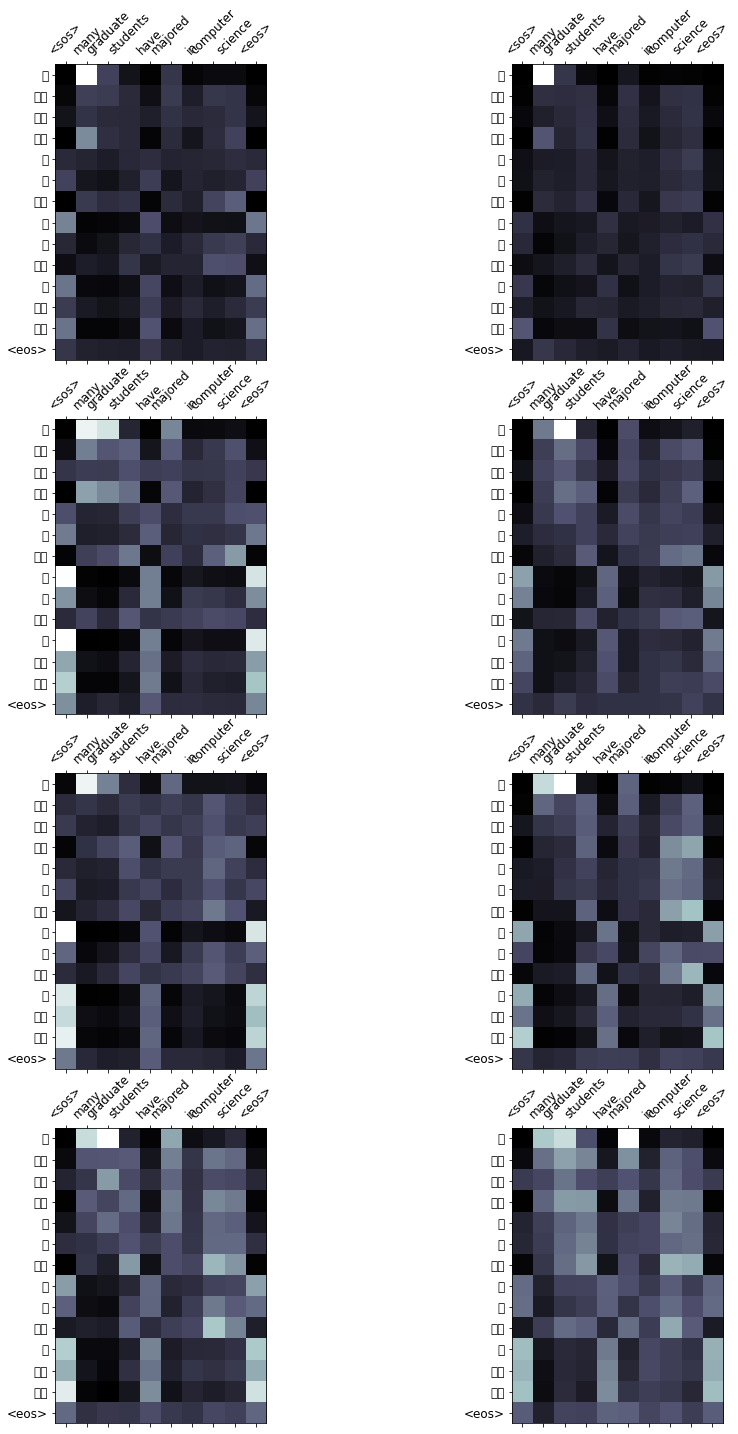

In [ ]:
src = clean_string(src)
english_tokens = src.split(' ')

display_attention(english_tokens, translation, attention)